<a href="https://colab.research.google.com/github/Mahjabeenqamar1/Real_Fake-FACE-DETECTION/blob/main/Final_real_fake_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahjabeenqamar1","key":"6c77d6ac7559c7e4ae31d55ee4409999"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
! kaggle datasets download xhlulu/140k-real-and-fake-faces

100% 3.74G/3.75G [01:05<00:00, 29.4MB/s]
100% 3.75G/3.75G [01:05<00:00, 61.1MB/s]


In [ ]:
!unzip /content/140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [ ]:
ls


140k-real-and-fake-faces.zip  kaggle.json    sample_data/  train.csv
drive/                        real_vs_fake/  test.csv      valid.csv


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense,MaxPool2D
import numpy as np
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

In [ ]:
nbatch = 128
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/real_vs_fake/real-vs-fake/train',
                                                 target_size=(128,128),
                                                 batch_size =nbatch,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('/content/real_vs_fake/real-vs-fake/test',
                                            target_size=(128,128),
                                            batch_size =nbatch,
                                            class_mode = 'binary')

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


Text(0.5, 0, 'Class')

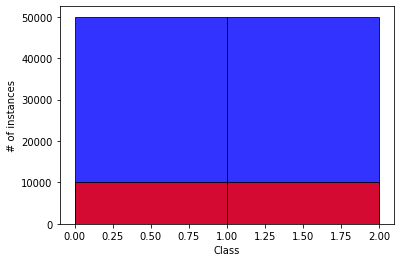

In [ ]:
h1 = plt.hist(training_set.classes, bins=range(0,3), alpha=0.8, color='blue', edgecolor='black')
h2 = plt.hist(test_set.classes,  bins=range(0,3), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class')


(128, 128, 128, 3) (128,)


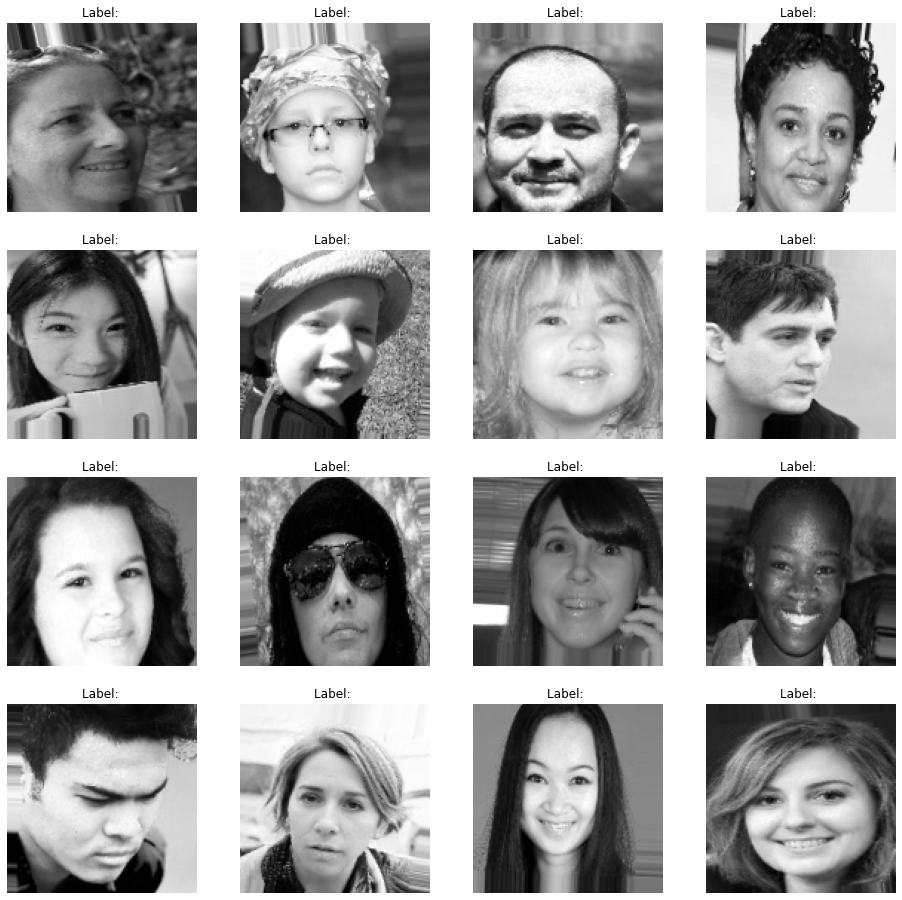

In [ ]:
for X, y in training_set:
    print(X.shape, y.shape)
    plt.figure(figsize=(16,16))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.title('Label: ')
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(128,128,3)))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(activation="relu",
                units=256))

model.add(Dense(activation="sigmoid",
                units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='model_checkpoint.hdf5', monitor='val_loss', save_best_only=True, mode ='max'),
]

In [ ]:
history = model.fit_generator(
        training_set,
        steps_per_epoch=80,
        epochs=10,
        validation_data=test_set,
        validation_steps=28,
        callbacks = callbacks_list
    )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
80/80 [==============================] - 252s 3s/step - loss: 0.7153 - accuracy: 0.5273 - val_loss: 0.6908 - val_accuracy: 0.5206
Epoch 2/10
80/80 [==============================] - 247s 3s/step - loss: 0.6836 - accuracy: 0.5548 - val_loss: 0.6780 - val_accuracy: 0.5703
Epoch 3/10
80/80 [==============================] - 252s 3s/step - loss: 0.6769 - accuracy: 0.5770 - val_loss: 0.6589 - val_accuracy: 0.6099
Epoch 4/10
80/80 [==============================] - 246s 3s/step - loss: 0.6601 - accuracy: 0.6029 - val_loss: 0.6353 - val_accuracy: 0.6392
Epoch 5/10
80/80 [==============================] - 248s 3s/step - loss: 0.6452 - accuracy: 0.6256 - val_loss: 0.6451 - val_accuracy: 0.6498
Epoch 6/10
80/80 [==============================] - 250s 3s/step - loss: 0.6342 - accuracy: 0.6480 - val_loss: 0.6046 - val_accuracy: 0.6705
Epoch 7/10
80/80 [==============================] - 247s 3s/step - loss: 0.6295 - accuracy: 0.6457 - val_loss: 0.6349 - val_accuracy: 0.6451
Epoch 8/10
80

In [ ]:
training_set.class_indices


{'fake': 0, 'real': 1}

Text(0.5, 0, '# of epochs')

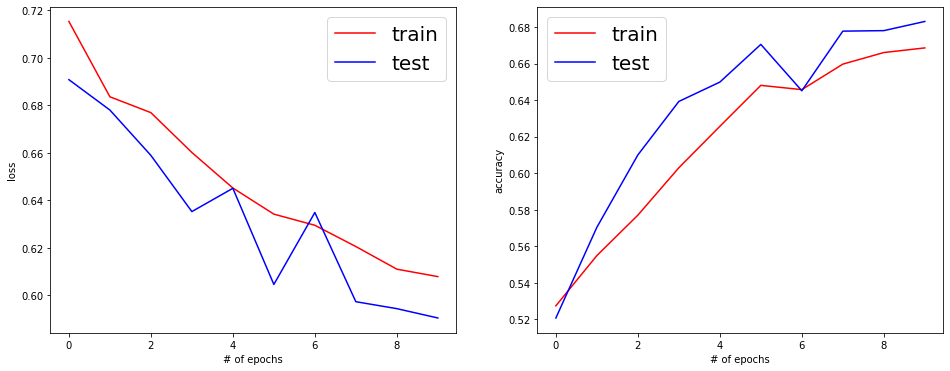

In [ ]:

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
nepochs=len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('loss')
plt.xlabel('# of epochs')
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['accuracy'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_accuracy'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('accuracy')
plt.xlabel('# of epochs')

In [ ]:
def ImagePrediction(loc):
    test_image = image.load_img(loc, target_size = (128,128))
    plt.axis('off')
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis =0)
    result = model.predict(test_image)
    if result[0][0] == 1:
        predictions = 'Real'
    else:
        predictions = 'Fake'
    print('Prediction: ',predictions)

Enter Location of Image to predict: /content/real_vs_fake/real-vs-fake/test/real/00001.jpg
Prediction:  Fake


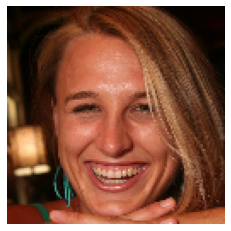

In [ ]:
img = input("Enter Location of Image to predict: ")
test_image_1 = ImagePrediction(img)

Enter Location of Image to predict: /content/real_vs_fake/real-vs-fake/test/real/00182.jpg
Prediction:  Fake


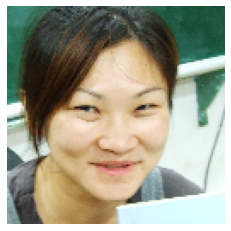

In [ ]:
img = input("Enter Location of Image to predict: ")
test_image_2 = ImagePrediction(img)

In [ ]:
 # Common imports
import os
import numpy as np

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [ ]:
# TensorFlow imports
# may differs from version to versions

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from keras.models import load_model
import cv2
import numpy as np 
import os



In [ ]:
# model = load_model('model-017.model')
model = os.path.join(os.getcwd(), 'model', '017')

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
import glob
import cv2
z=('/content/real_vs_fake/real-vs-fake/train/real')
#images = cv2.imread(file) for file in glob.glob("/content/real_vs_fake/real-vs-fake/train/real/*.png")

In [ ]:
from PIL import Image

In [ ]:

# for x in z:
#     image = Image.open(x,"r")
#     plt.imshow(image)
#     plt.show()

In [ ]:
import cv2
from pathlib import Path

path=Path("/content/real_vs_fake/real-vs-fake/train/real/Rael_2000/")

#path=path.glob("*.jpg")

images=[]


for imagepath in path.glob("*.jpg"):

        img=cv2.imread(str(imagepath))
        img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                         
        img=cv2.resize(img,(200,200))
        images.append(img)
print(images)

[]


In [ ]:
face_clsfr=cv2.CascadeClassifier('/content/drive/MyDrive/New folder/haarcascade_frontalface_default.xml')

# source=cv2.VideoCapture(2)

labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [ ]:
while(True):

   # ret,img=images.read()
    ret,img = images
    gray=cv2.cvtColor(images,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

#     for (x,y,w,h) in faces:
    
#         face_img=gray[y:y+w,x:x+w]
#         resized=cv2.resize(face_img,(100,100))
#         normalized=resized/255.0
#         reshaped=np.reshape(normalized,(1,100,100,1))
#         result=model.predict(reshaped)

#         label=np.argmax(result,axis=1)[0]
      
#         cv2.rectangle(images,(x,y),(x+w,y+h),color_dict[label],2)
#         cv2.rectangle(images,(x,y-40),(x+w,y),color_dict[label],-1)
#         cv2.putText(images, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
#     cv2.imshow('LIVE',images)
#     key=cv2.waitKey(1)
    
#     if(key==27):
#         break
        
# cv2.destroyAllWindows()
# source.release()

ValueError: ignored